# Read flux power for different models / snapshots / temperatures / tau

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Specify suite of simulations to use and read metadata

In [3]:
basedir='../sim_suites/emulator_512_17052019/'
cube_json=basedir+'/latin_hypercube.json'
with open(cube_json) as json_file:  
    cube_data = json.load(json_file)
nsamples=cube_data['nsamples']
print('# samples =',nsamples)
# label identifying the particular skewer extraction (number of skewers per side and cell width in Mpc)
skewer_label='Ns100_wM0.07'

# samples = 10


### Get information from all models simulated (simulation pairs)

In [4]:
p1d_arxiv = []
for sample in range(nsamples):
    # store parameters for simulation pair / model
    sim_params = cube_data['samples']['%d'%sample]
    print(sample,'sim params',sim_params)
    model_dict ={'sample':sample,'sim_param':sim_params}
    # read number of snapshots 
    pair_dir=basedir+'/sim_pair_%d'%sample
    pair_json=pair_dir+'/parameter.json'
    with open(pair_json) as json_file:  
        pair_data = json.load(json_file)
    #print(sample,'pair data',pair_data)
    zs=pair_data['zs']
    Nz=len(zs)
    
    for snap in range(Nz):        
        # make sure that we actually extracted skewers for this snapshot (z < zmax)
        plus_p1d_json=pair_dir+'/sim_plus/p1d_{}_{}.json'.format(snap,skewer_label)
        if not os.path.isfile(plus_p1d_json):
            print('do not have this snapshot',snap)
            continue
            
        # get linear power parameters describing snapshot
        linP = pair_data['linP_zs'][snap]
        z=zs[snap]
        
        # open file describing 1D power measured in snapshot for sim_plus
        with open(plus_p1d_json) as json_file: 
            plus_data = json.load(json_file)
        # open file describing 1D power measured in snapshot for sim_minus            
        minus_p1d_json=pair_dir+'/sim_minus/p1d_{}_{}.json'.format(snap,skewer_label)
        with open(minus_p1d_json) as json_file: 
            minus_data = json.load(json_file)

        # number of post-process rescalings for each snapshot
        Npp=len(plus_data['p1d_data'])
        # read info for each post-process
        for pp in range(Npp):
            p1d_data = {'linP':linP, 'z':z}
            p1d_data['k_Mpc'] = np.array(plus_data['p1d_data'][pp]['k_Mpc'])
            plus_pp = plus_data['p1d_data'][pp]
            minus_pp = minus_data['p1d_data'][pp]
        
            # average plus + minus stats
            plus_mF = plus_pp['mF']
            minus_mF = minus_pp['mF']
            pair_mF = 0.5*(plus_mF+minus_mF)
            p1d_data['mF'] = pair_mF 
            p1d_data['T0'] = 0.5*(plus_pp['sim_T0']+minus_pp['sim_T0'])
            p1d_data['gamma'] = 0.5*(plus_pp['sim_gamma']+minus_pp['sim_gamma'])
            p1d_data['sigT_Mpc'] = 0.5*(plus_pp['sim_sigT_Mpc']+minus_pp['sim_sigT_Mpc'])
            if 'kF_Mpc' in plus_pp:
                p1d_data['kF_Mpc'] = 0.5*(plus_pp['kF_Mpc']+minus_pp['kF_Mpc'])
            plus_p1d = np.array(plus_pp['p1d_Mpc'])
            minus_p1d = np.array(minus_pp['p1d_Mpc'])
            # compute average of < F F >, not <delta delta> 
            pair_p1d = (plus_p1d * plus_mF**2 + minus_p1d * minus_mF**2) / pair_mF
            p1d_data['p1d_Mpc'] = pair_p1d
            p1d_arxiv.append(p1d_data)        

0 sim params [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002]
do not have this snapshot 0
do not have this snapshot 1
do not have this snapshot 2
do not have this snapshot 3
do not have this snapshot 4
do not have this snapshot 5
do not have this snapshot 6
1 sim params [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475]
do not have this snapshot 0
do not have this snapshot 1
do not have this snapshot 2
do not have this snapshot 3
do not have this snapshot 4
do not have this snapshot 5
do not have this snapshot 6
2 sim params [0.966, 0.3, -2.305, -0.26, 1.025, 0.875]
do not have this snapshot 0
do not have this snapshot 1
do not have this snapshot 2
do not have this snapshot 3
do not have this snapshot 4
do not have this snapshot 5
do not have this snapshot 6
3 sim params [0.956, 0.4, -2.275, -0.25, 0.575, 1.175]
do not have this snapshot 0
do not have this snapshot 1
do not have this snapshot 2
do not have this snapshot 3
do not have this snapshot 

In [5]:
Ntot=len(p1d_arxiv)
max_size=1000
keep=np.random.randint(0,Ntot,max_size)
keep_data=[p1d_arxiv[i] for i in keep]
p1d_arxiv=keep_data
Ntot=len(p1d_arxiv)

In [6]:
# IGM parameters
mF=np.array([p1d_arxiv[i]['mF'] for i in range(Ntot)])
T0=np.array([p1d_arxiv[i]['T0'] for i in range(Ntot)])
gamma=np.array([p1d_arxiv[i]['gamma'] for i in range(Ntot)])
if 'kF_Mpc' in p1d_arxiv[0]:
    kF_Mpc=np.array([p1d_arxiv[i]['kF_Mpc'] for i in range(Ntot)])
# linear power parameters 
Delta2_p=np.array([p1d_arxiv[i]['linP']['Delta2_p'] for i in range(Ntot)])
n_p=np.array([p1d_arxiv[i]['linP']['n_p'] for i in range(Ntot)])
alpha_p=np.array([p1d_arxiv[i]['linP']['alpha_p'] for i in range(Ntot)])
f_p=np.array([p1d_arxiv[i]['linP']['f_p'] for i in range(Ntot)])
# hidden parameters (should not be fed to the emulator)
z=np.array([p1d_arxiv[i]['z'] for i in range(Ntot)])

In [7]:
print(Ntot)

1000


In [8]:
def plot_p1d_dependence(val,tag):
    imin=np.argmin(val)
    imax=np.argmax(val)
    min_val=val[imin]
    max_val=val[imax]
    plt.figure(figsize=[10,4])
    # first power spectrum for delta_flux
    plt.subplot(1, 2, 1)
    for i in range(Ntot):
        k_Mpc=p1d_arxiv[i]['k_Mpc']
        p1d_Mpc=p1d_arxiv[i]['p1d_Mpc']
        col = plt.cm.jet((val[i]-min_val)/(max_val-min_val))
        if i in [imin,imax]:
            label=tag+' = %f'%val[i]
        else:
            label=None
        plt.semilogx(k_Mpc,k_Mpc*p1d_Mpc,color=col,label=label)
    plt.xlabel(r'$k_\parallel$ [1/Mpc]')
    plt.ylabel(r'$k_\parallel \quad P_{\delta}(k_\parallel)$')
    plt.legend()
    plt.title(r'P1D of $\delta_F$ as a function of '+tag)
    # then power spectrum for F  
    plt.subplot(1, 2, 2)
    for i in range(Ntot):
        k_Mpc=p1d_arxiv[i]['k_Mpc']
        p1d_Mpc=p1d_arxiv[i]['p1d_Mpc']
        mF=p1d_arxiv[i]['mF']
        p1d_Mpc_F = p1d_Mpc * mF**2
        col = plt.cm.jet((val[i]-min_val)/(max_val-min_val))
        if i in [imin,imax]:
            label=tag+' = %f'%val[i]
        else:
            label=None
        plt.semilogx(k_Mpc,k_Mpc*p1d_Mpc_F,color=col,label=label)
    plt.xlabel(r'$k_\parallel$ [1/Mpc]')
    plt.ylabel(r'$k_\parallel \quad P_F(k_\parallel)$')
    plt.legend()
    plt.title(r'P1D of $F$ as a function of '+tag)

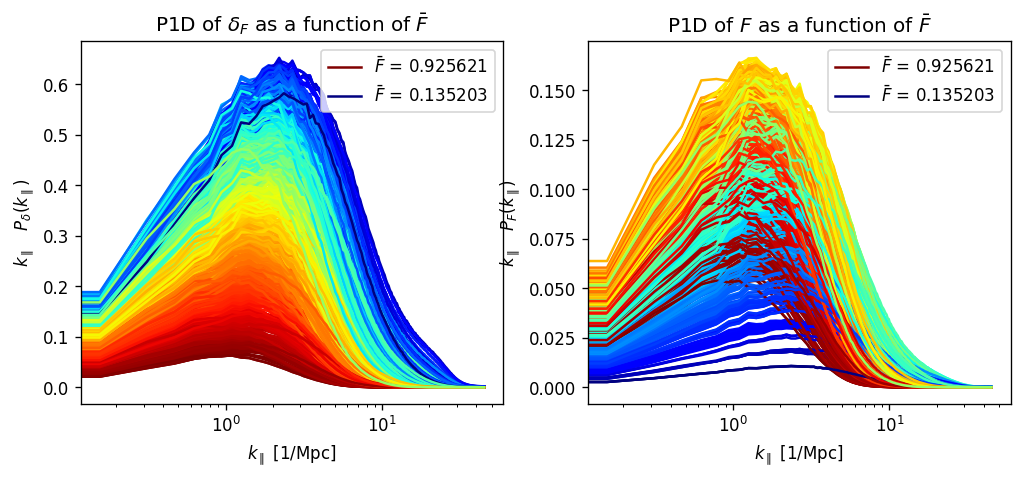

In [9]:
plot_p1d_dependence(mF,r'$\bar F$')

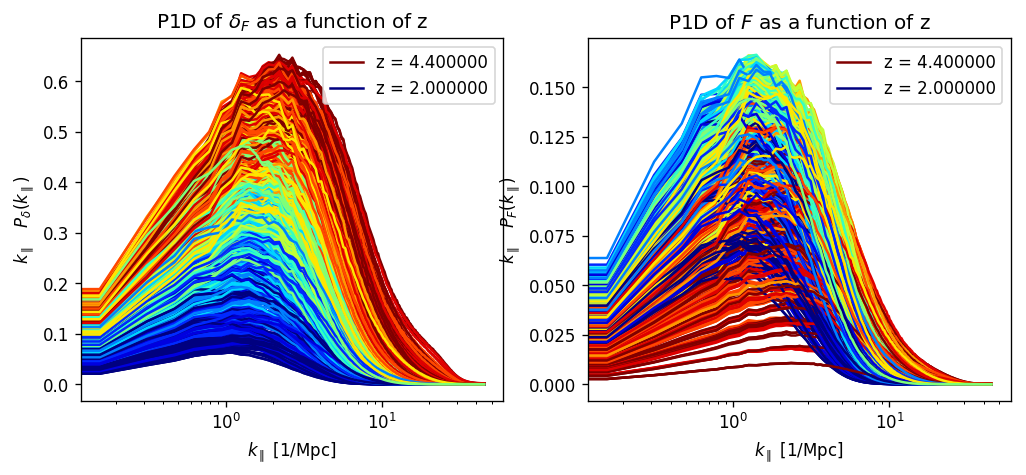

In [10]:
plot_p1d_dependence(z,'z')

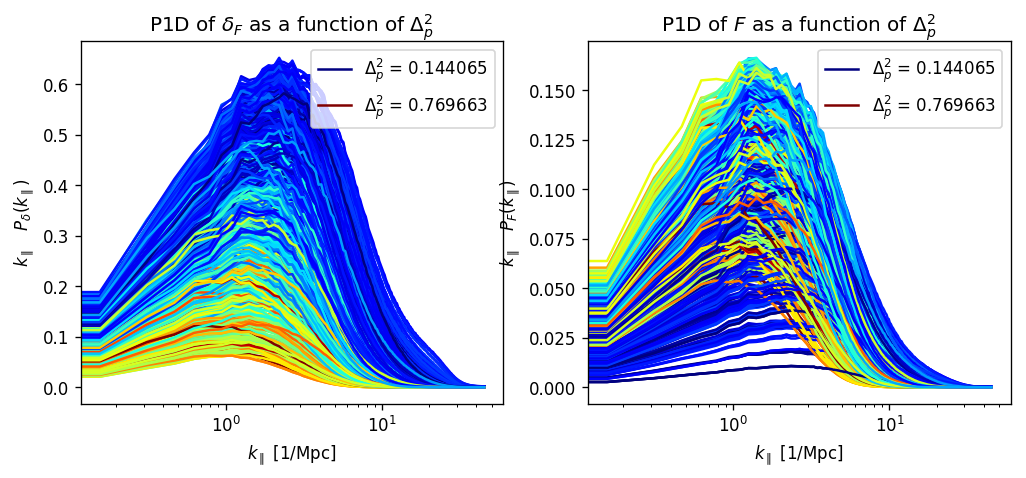

In [11]:
plot_p1d_dependence(Delta2_p,r'$\Delta_p^2$')

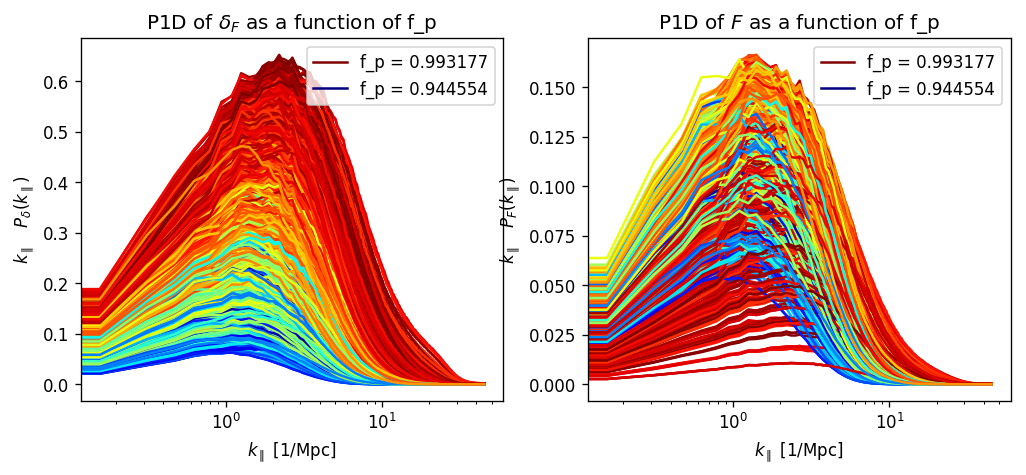

In [12]:
plot_p1d_dependence(f_p,'f_p')

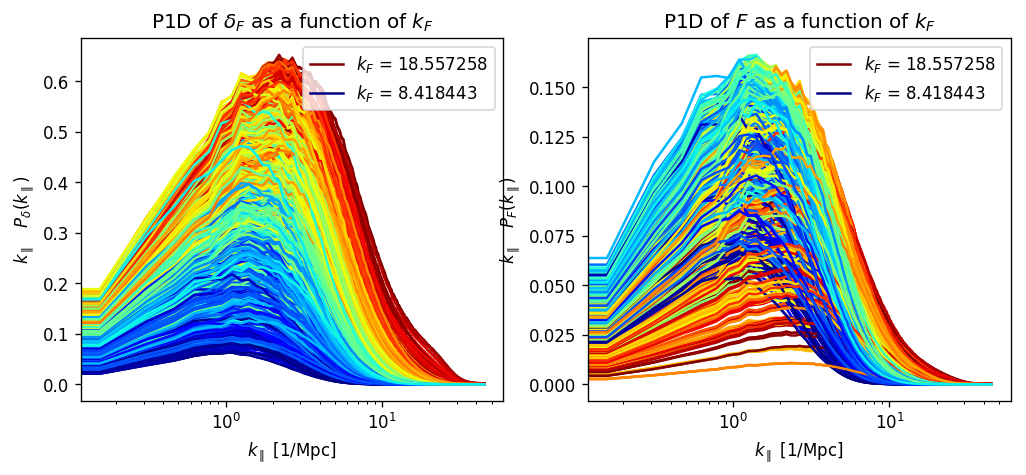

In [13]:
if 'kF_Mpc' in p1d_arxiv[0]:
    plot_p1d_dependence(kF_Mpc,r'$k_F$')